In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import gc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# прописывем нужные нам пути
dir_project = 'proj_news_radar/proj_news_viz/nlp' # путь проекта

PATH = os.path.join(os.getenv('HOME'), dir_project)
sys.path.append(PATH)

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

---
возьмем для примера датасет [lenta.ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)

для примера взят датасет, скаченный по линку с gitHub

In [81]:
df = pd.read_csv(f'{PATH}/data/external/news_lenta.csv')
print(df.shape)
df.sample(2)

(699746, 5)


,tags,text,title,topic,url
202886,NaN,Американская компания Bell Helicopter представ...,Bell представила военным проект нового конверт...,Силовые структуры,https://lenta.ru/news/2014/07/14/robotpoles/
354171,Все,Бывшего вратаря сборной России по футболу Вени...,Вениамин Мандрыкин вышел из комы,Спорт,https://lenta.ru/news/2010/11/13/metallica/


немного запрепроцессим датасет

In [82]:
# удалим пустые записи и дубликаты по признаку `text`
df.dropna(inplace=True)
df.text.drop_duplicates(inplace=True)

print(f'df.shape: {df.shape}')
df.isnull().sum()

df.shape: (675697, 5)


tags     0
text     0
title    0
topic    0
url      0
dtype: int64

In [83]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
print(f'\nих распределение:\n{df.topic.value_counts()}')

уникальное к-ство разделов: 23

их распределение:
Россия               153054
Мир                  134334
Экономика             74643
Спорт                 56840
Культура              52337
Наука и техника       51869
Бывший СССР           50674
Интернет и СМИ        43071
Из жизни              26264
Силовые структуры     10107
Бизнес                 7374
Ценности               6832
Путешествия            6005
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64


In [16]:
# выберем для примера топ-5 разделов
df_top5 = df[df.topic.isin(df.topic.value_counts().head(5).index)]
df_top5.shape

(471208, 5)

---
закодируем кат-фичи

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# обучаем энкодер

le = LabelEncoder()

le.fit(df_top5.topic)
list(le.classes_)

['Культура', 'Мир', 'Россия', 'Спорт', 'Экономика']

In [19]:
# применяем 
le.transform(df_top5.topic) 

array([1, 4, 1, ..., 2, 1, 1])

In [20]:
# посмотрим какое число описывает раздел "Россия"
le.transform(['Россия'])

array([2])

In [21]:
# добавим новый признак заэнкодженных разделов к нашему датасету в качестве таргета
df_top5['target'] = le.transform(df_top5.topic)
df_top5.head()

df_top5.sample(5)

,tags,text,title,topic,url,target
404474,Все,"Двое футболистов, выступающих в чемпионате Укр...",Футболисты из Белоруссии и Украины попались на...,Спорт,https://lenta.ru/news/2009/09/24/norevisionism/,3
413484,Все,В Белоруссии с 15 июля в обращение поступит пр...,В Белоруссии выпустят в обращение прямоугольну...,Экономика,https://lenta.ru/news/2009/07/14/arch/,4
678879,Все,"Вечно молодая Шер, знаменитая певица, актриса,...",Шер искупается в крови девственниц,Культура,https://lenta.ru/news/2001/01/29/kurchaloy/,0
297679,Все,"Командир экипажа вертолета Ка-52, разбившегося...",Скончался командир экипажа разбившегося Ка-52,Россия,https://lenta.ru/news/2012/03/13/macedonia/,2
453525,Все,"Школьный учитель, опубликовавший в интернете в...",Учителю из Миссури грозит суд за видео в подде...,Мир,https://lenta.ru/news/2008/10/07/funeral/,1


---
сплитим данные 

In [22]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_top5.text,df_top5.target,
                                                    test_size=0.2,
                                                    stratify=df_top5.target,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376966,), (94242,), (376966,), (94242,))

In [25]:
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [71]:
def plot_frequency(vocab: list=None, top_words: int=30) -> None:
    '''
    plot token frequency
    
    Parameters
    ----------
        vocab: list
            list tuples words with them frequency
            like `[('на', 1330966), ... ]`
            
        top_words: int (defauld=30)
            enter top words to plot
    '''
    
    x, y = [], []
    for key, val in vocab[:top_words]:
        x.append(key)
        y.append(val)
        
    plt.figure(figsize=(20,10), )
    plt.bar(x,y)
    plt.title(f'топ-{top_words} частотных слов')
    plt.xlabel('слова', horizontalalignment='center')
    plt.ylabel('частотность')
    

* ### без препроцессинга

In [29]:
%%time
count_vect = CountVectorizer(min_df=0.1)

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 55.5 s, sys: 667 ms, total: 56.1 s
Wall time: 56.2 s


In [51]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('на', 1310739),
 ('по', 800310),
 ('что', 757900),
 ('не', 531170),
 ('из', 398442),
 ('за', 338746),
 ('года', 300748),
 ('как', 291761),
 ('его', 231913),
 ('он', 226912)]

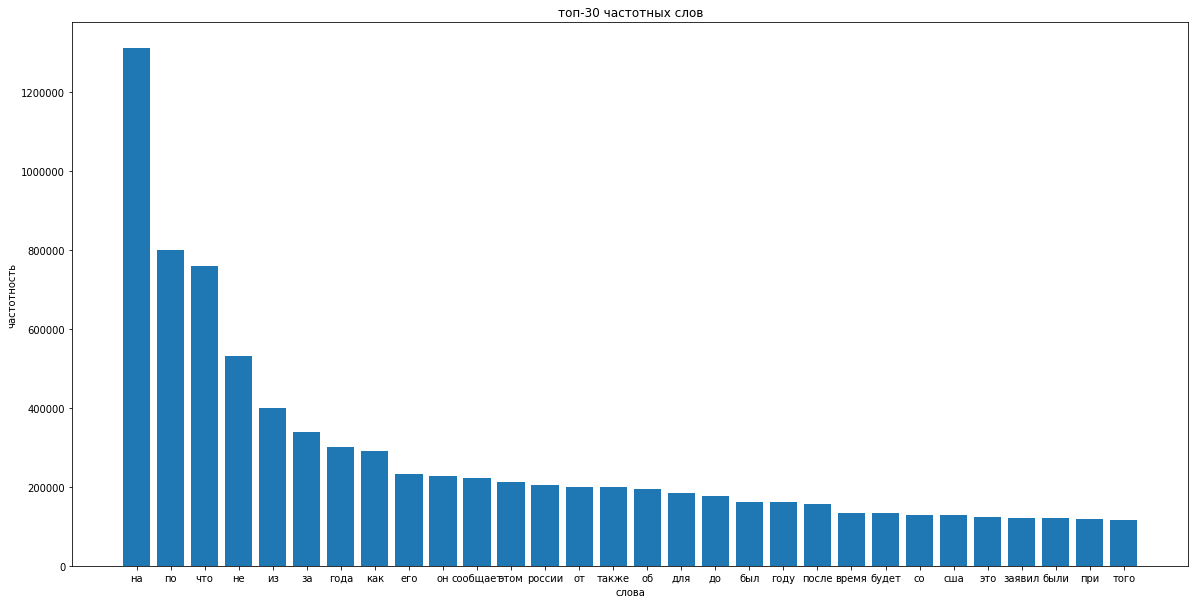

In [57]:
plot_frequency(vocab, 30)

In [58]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5, target_names=le.classes_)}')
print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.47784   0.59339   0.52938     10467
         Мир    0.70234   0.67615   0.68899     26867
      Россия    0.73543   0.63592   0.68206     30611
       Спорт    0.57447   0.71622   0.63756     11368
   Экономика    0.68840   0.67955   0.68395     14929

    accuracy                        0.65926     94242
   macro avg    0.63570   0.66024   0.64439     94242
weighted avg    0.67052   0.65926   0.66201     94242


confusion_matrix:
[[ 6211  1114  1164  1393   585]
 [ 2418 18166  3216  1775  1292]
 [ 2237  4507 19466  2128  2273]
 [ 1301   801   682  8142   442]
 [  831  1277  1941   735 10145]]
CPU times: user 1min 9s, sys: 59.9 ms, total: 1min 9s
Wall time: 1min 9s


In [26]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', CountVectorizer(min_df=0.1)),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

* ### c препроцессингом

In [61]:
from news_viz.data_processing.preprocessing_tools import clean_text, lemmatization

import multiprocessing as mp
from multiprocessing import Pool
num_cores = int(mp.cpu_count() / 1.2) # number of cores on your machine; 20
num_partitions = num_cores * 2        # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [62]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* clean text

In [63]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [64]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text!='9999']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text!='9999']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 7.39 s, sys: 6.87 s, total: 14.3 s
Wall time: 15.3 s


0

* lemmatization

In [65]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatization)
    return data

In [66]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text!='9999']

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text!='9999']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 13.9 s, sys: 13 s, total: 27 s
Wall time: 10min 11s


0

In [67]:
print(train.shape, test.shape)
train.head(2)

(376809, 4) (94199, 4)


,text,target,clean_text,lemma_text
166270,С вечера пятницы и до утра субботы в столице в...,2,вечера пятницы до утра субботы столице выпала ...,вечер пятница утро суббота столица выпасть мес...
68433,Губернатор Нижегородской области Валерий Шанце...,2,губернатор нижегородской области валерий шанце...,губернатор нижегородский область валерий шанце...


---
_на случай, если не хватает памяти_

In [ ]:
train[['lemma_text','target']].to_csv(f'{PATH}/data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(f'{PATH}/data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [ ]:
train = pd.read_csv(f'{PATH}/data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(f'{PATH}/data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip')

In [ ]:
print(train.shape, test.shape)
train.sample(2)

---
* обучаем модель

In [68]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [69]:
%%time
count_vect = CountVectorizer(min_df=0.1)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 35.4 s, sys: 565 ms, total: 35.9 s
Wall time: 35.9 s


In [72]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('год', 568555),
 ('который', 331998),
 ('россия', 261401),
 ('сообщать', 233241),
 ('один', 191689),
 ('заявить', 167802),
 ('свой', 152911),
 ('процент', 149571),
 ('российский', 147262),
 ('страна', 143637)]

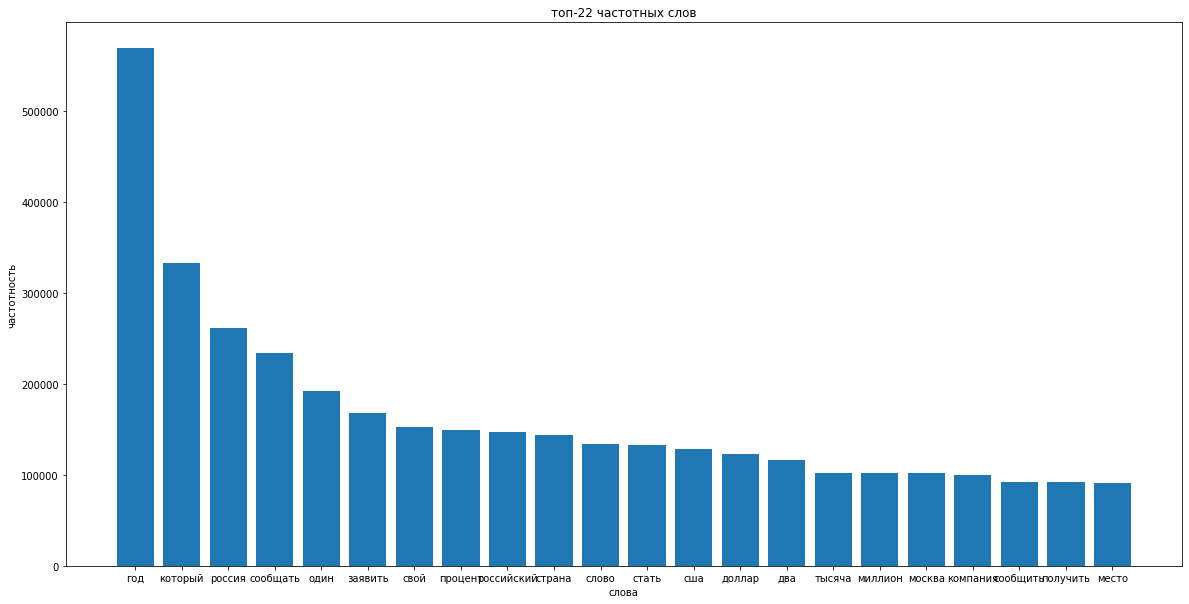

In [80]:
plot_frequency(vocab, 22)

In [74]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5, target_names=le.classes_)}')
print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.53519   0.61411   0.57194     10464
         Мир    0.73510   0.71851   0.72671     26854
      Россия    0.77159   0.69446   0.73100     30592
       Спорт    0.63170   0.75895   0.68951     11363
   Экономика    0.74373   0.73536   0.73952     14926

    accuracy                        0.70665     94199
   macro avg    0.68346   0.70428   0.69174     94199
weighted avg    0.71364   0.70665   0.70845     94199


confusion_matrix:
[[ 6426   997  1090  1478   473]
 [ 1825 19295  3043  1424  1267]
 [ 1768  4067 21245  1693  1819]
 [ 1262   676   578  8624   223]
 [  726  1213  1578   433 10976]]
CPU times: user 1min 1s, sys: 63.8 ms, total: 1min 1s
Wall time: 1min 1s


### как видим, очистка текста улучшила метрики на несколько пунктов